# XAI - TABNET

## Loading libraries

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os
import shutil
import tensorflow as tf
import tabnet

## Utilities

In [10]:
def plot_masks(model):
    for mask in model.tabnet.feature_selection_masks:
        fig, ax = plt.subplots(figsize=(5, 20))
        ax.imshow(mask[0])
        plt.xticks(range(len(numerical_features)), numerical_features, rotation="vertical") 
        plt.show()

    fig, ax = plt.subplots(figsize=(5, 20))
    ax.imshow(model.tabnet.aggregate_feature_selection_mask[0])
    plt.xticks(range(len(numerical_features)), numerical_features, rotation="vertical") 
    plt.show()

In [11]:
def plot_averaged_masks(model):
    for mask in model.tabnet.feature_selection_masks:
        fig, ax = plt.subplots(figsize=(5, 10))
        avg = np.mean(mask[0], axis=0)
        ax.imshow([avg/np.sum(avg)])
        plt.xticks(range(len(numerical_features)), numerical_features, rotation="vertical")
        plt.yticks([])
        plt.show()

    fig, ax = plt.subplots(figsize=(5, 10))
    avg = np.mean(model.tabnet.aggregate_feature_selection_mask[0], axis=0)
    ax.imshow([np.array(avg)/np.sum(avg)])
    plt.xticks(range(len(numerical_features)), numerical_features, rotation="vertical")
    plt.yticks([])
    plt.show()

## Loading data

In [12]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 2353593986 to 933183398
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    11508 non-null  object 
 1   lang                    11508 non-null  object 
 2   bot                     11508 non-null  int64  
 3   created_at              11508 non-null  object 
 4   statuses_count          11508 non-null  int64  
 5   avg_length              11508 non-null  float64
 6   avg_special_chars       11508 non-null  float64
 7   urls_ratio              11508 non-null  float64
 8   mentions_ratio          11508 non-null  float64
 9   hashtags_ratio          11508 non-null  float64
 10  reply_count_mean        11508 non-null  float64
 11  reply_count_std         11508 non-null  float64
 12  favorite_count_mean     11508 non-null  float64
 13  favorite_count_std      11508 non-null  float64
 14  favorite_count_entropy  1

In [14]:
data.head()

,name,lang,bot,created_at,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std
2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.037879,0.190903,0.232481,0.037879,0.190903
2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.049587,0.217090,0.284639,0.024793,0.155495
137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,53,65.340909,14.694444,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.165387,0.530838,0.669155,0.826239,13.034008
2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.056365,0.243387,0.317182,0.016772,0.142619


## Preprocessing of the data

In [15]:
target = data.pop('bot')

In [16]:
# convert datetime to timestamp to permit classification
# data["created_at"] = pd.to_datetime(data.created_at).values.astype(np.int64) // 10 ** 9
del data["created_at"]

In [17]:
# categorical_features = ["lang", "bot", "created_at", "name"]
categorical_features = ["lang", "name"]

# remove categorical variables
numerical_features = list(data.columns).copy()

for feat in categorical_features:
    numerical_features.remove(feat)

In [18]:
numerical_features

['statuses_count',
 'avg_length',
 'avg_special_chars',
 'urls_ratio',
 'mentions_ratio',
 'hashtags_ratio',
 'reply_count_mean',
 'reply_count_std',
 'favorite_count_mean',
 'favorite_count_std',
 'favorite_count_entropy',
 'retweet_count_mean',
 'retweet_count_std']

In [19]:
numerical_data = data[numerical_features]

In [20]:
numerical_data.head()

,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std
2353593986,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.037879,0.190903,0.232481,0.037879,0.190903
2358850842,54,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.049587,0.217090,0.284639,0.024793,0.155495
137959629,53,65.340909,14.694444,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
466124818,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.165387,0.530838,0.669155,0.826239,13.034008
2571493866,7085,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.056365,0.243387,0.317182,0.016772,0.142619


In [21]:
target.head()

2353593986    1
2358850842    0
137959629     1
466124818     1
2571493866    0
Name: bot, dtype: int64

In [22]:
numerical_dataset = tf.data.Dataset.from_tensor_slices((numerical_data, target))

2022-12-14 23:22:36.425272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
def transform(data, target):
    data = tf.unstack(data)
    
    x = dict(zip(numerical_features, data))
    y = tf.one_hot(target, 2)
    
    return x, y

In [24]:
BATCH_SIZE = 128

train_size = int(data.shape[0] / 100 * 70)

In [25]:
ds_full = numerical_dataset.shuffle(data.shape[0], seed=0)
# ds_full = numerical_dataset

In [26]:
ds_train = ds_full.take(train_size)
ds_train = ds_train.map(transform)
ds_train = ds_train.batch(BATCH_SIZE)
ds_test = ds_full.skip(train_size)
ds_test = ds_test.map(transform)
ds_test = ds_test.batch(BATCH_SIZE)

feature_columns = []
for col_name in numerical_features:
    feature_columns.append(tf.feature_column.numeric_column(col_name))

In [27]:
feature_columns

[NumericColumn(key='statuses_count', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='avg_length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='avg_special_chars', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='urls_ratio', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='mentions_ratio', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='hashtags_ratio', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='reply_count_mean', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='reply_count_std', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='favorite_count_mean', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='favor

## Defining and training the model

In [30]:
# Group Norm does better for small datasets
model = tabnet.TabNetClassifier(feature_columns, num_classes=2,
                                feature_dim=8, output_dim=4,
                                num_decision_steps=4, relaxation_factor=1.0,
                                sparsity_coefficient=1e-5, batch_momentum=0.98,
                                virtual_batch_size=None, norm_type='group',
                                num_groups=1)
                                

lr = tf.keras.optimizers.schedules.ExponentialDecay(0.0012, decay_steps=100, decay_rate=0.9, staircase=False)
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

[TabNet]: 4 features will be used for decision steps.


In [31]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

model.fit(ds_train, epochs=100, validation_data=ds_test, callbacks=[early_stopping_callback])

model.summary()

Epoch 1/100
63/63 [==============================] - 9s 29ms/step - loss: 0.4583 - accuracy: 0.8333 - val_loss: 0.3716 - val_accuracy: 0.8546
Epoch 2/100
63/63 [==============================] - 1s 9ms/step - loss: 0.3588 - accuracy: 0.8535 - val_loss: 0.3453 - val_accuracy: 0.8543
Epoch 3/100
63/63 [==============================] - 1s 9ms/step - loss: 0.3387 - accuracy: 0.8649 - val_loss: 0.3321 - val_accuracy: 0.8700
Epoch 4/100
63/63 [==============================] - 1s 9ms/step - loss: 0.3359 - accuracy: 0.8685 - val_loss: 0.3365 - val_accuracy: 0.8671
Epoch 5/100
63/63 [==============================] - 1s 9ms/step - loss: 0.3323 - accuracy: 0.8677 - val_loss: 0.3331 - val_accuracy: 0.8697
Epoch 6/100
63/63 [==============================] - 1s 9ms/step - loss: 0.3302 - accuracy: 0.8694 - val_loss: 0.3236 - val_accuracy: 0.8740
Epoch 7/100
63/63 [==============================] - 1s 9ms/step - loss: 0.3282 - accuracy: 0.8715 - val_loss: 0.3402 - val_accuracy: 0.8598
Epoch 8/100


## Evaluation and explanation plots

In [32]:
results = model.evaluate(ds_test, batch_size=128)
print("test loss, test acc:", results)

27/27 [==============================] - 0s 4ms/step - loss: 0.3239 - accuracy: 0.8694
test loss, test acc: [0.32393893599510193, 0.8693889379501343]


In [33]:
# Force eager execution mode to generate the masks
x, y = next(iter(ds_train))

_ = model(x)

### Explanations

More yellow cells indicate the most important features for a certain sample.
In the following plots we can see the masks generated by the TabNet algorithm. The last one is the aggregation of the previous ones.

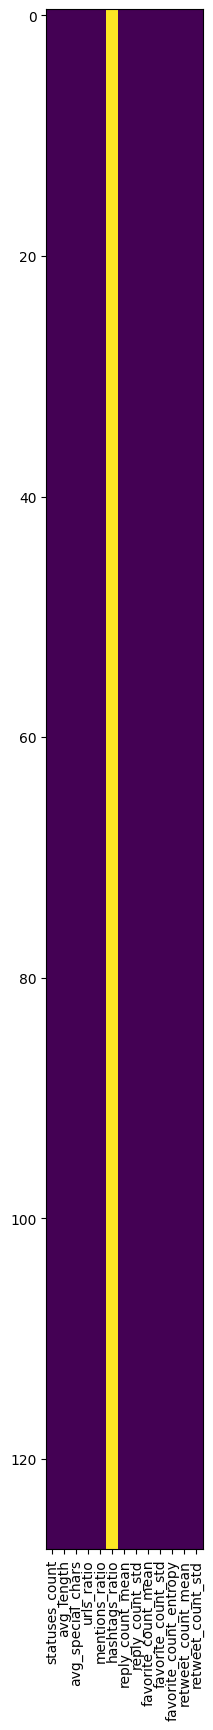

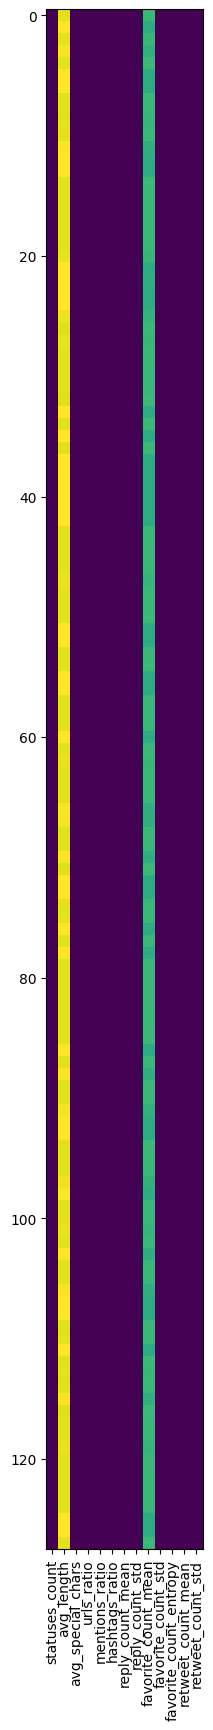

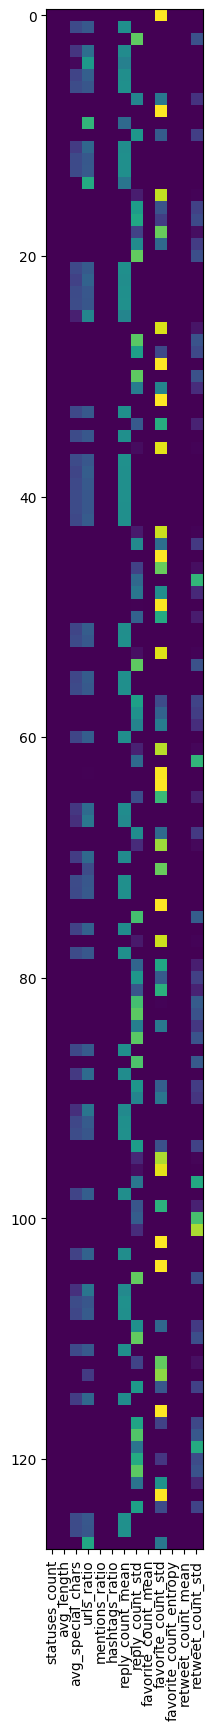

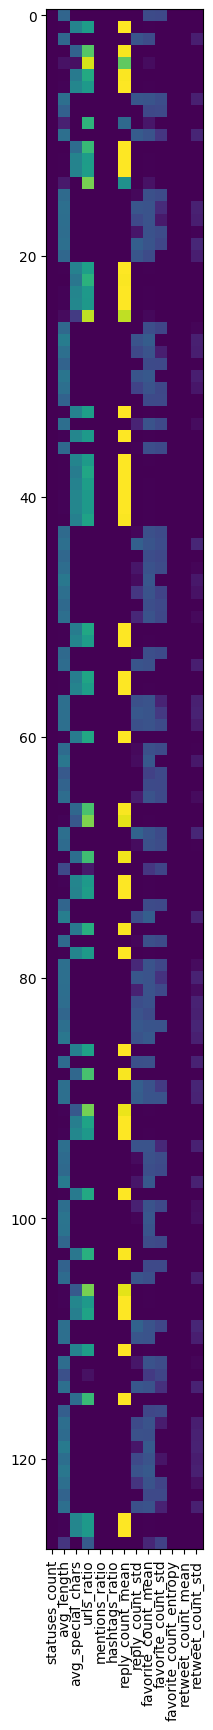

In [34]:
plot_masks(model)

Now we report the average of the masks over the different samples.

We can see in the aggregation that the most important feature is the **favourite_count_entropy**, this is not consistent with the other results get from the other XAI methods.

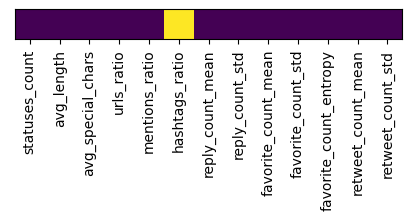

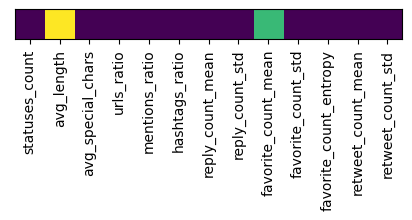

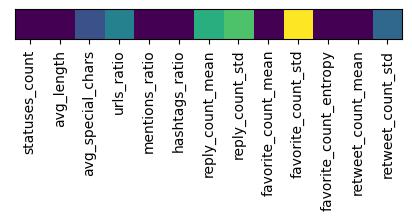

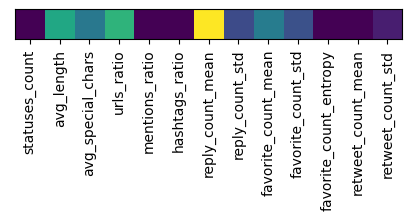

In [35]:
plot_averaged_masks(model)